In [1]:
import numpy as np
import torch
import urllib.request as urllib
import matplotlib.pyplot as plt
import pickle

import os
import sys
sys.path.append('src')

from util.loss_util import L2_Bern_loss_corrected, L2_Bern_loss
from util.model_util import RegressionNet
from datasets.toy import load_1d, RegressionData
from datasets.samplers import Bernoulli_batch_sampler, naive_Bernoulli_Dataloader
from uncertimators.MCMC_Adam_unc import MCMC_Adam_uncertimator

import seaborn as sns

# Set the color palette to a colorblind-friendly palette
sns.set_palette('colorblind')

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"


/beegfs/desy/user/bierings/conda/envs/bayesconda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
pal = sns.color_palette('colorblind')
pal

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [3]:
print(pal.as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [5]:
def plot_doc_dict(doc_dict):  
    n_figs = len(doc_dict.keys())
    if n_figs < 10:
        fig, ax = plt.subplots(5,2, figsize = (20,25))
    else:
        fig, ax = plt.subplots(6,4, figsize = (20,30))
    ax = ax.flatten()

    for i, key in enumerate(doc_dict.keys()):
        if not key == 'acceptance_prob':
            p3 = ax[i].plot(doc_dict[key], label = r'$\sigma$ constant, start lr $ = 10^{-3}$')
        if key == 'acceptance_prob':
            ax[i].set_ylim(-0.1,1.5)
            t = np.mean(np.clip(np.array(doc_dict[key]),0,1))
            p3 = ax[i].plot(np.clip(np.array(doc_dict[key]),0,1), label = r'$\sigma$ constant, start lr $ = 10^{-3}$')
            ax[i].text(0,1, f'mean acc-prob {t:.3}', bbox = {'color': p3[0].get_color()})
        if key in ['sigma', 'old_new_sqe', 'prop_next_sqe', 'lr']:
            ax[i].set_yscale('log')
        #if 'loss' in key:
            #ax[i].hlines(-0.8,0,len(uncert.doc_dict[key]), color='r')
            
        ax[i].set_title(key)
        ax[i].grid()   
        #ax[i].vlines(doc_dict['steps_sampling'], ax[i].get_ylim()[0],ax[i].get_ylim()[1]*0.1, color='orange')
    ax[0].legend()
    #fig.savefig(folder + '/tau_comparison_adam.pdf')#
    plt.show()

In [6]:
def get_quantile(Y_sampled, alpha = 0.05):
    deviation = (Y_sampled - Y_sampled.mean(0, keepdims = True))**2
    z_k = deviation.mean(1)
    q = np.quantile(z_k, 1-alpha)

    return q

def get_quantile_theta(net, path, alpha = 0.05):

    dirs = os.listdir(path+'/samples/')

    z_k_theta = np.zeros(len(dirs))

    for i in range(len(dirs)):
        file = path+f'/samples/sample_{i}/model.pt'
        net.load_state_dict(torch.load((file)))
        params  = torch.nn.utils.parameters_to_vector(net.parameters())
        z_k_theta[i] = params.max()
    
    q = np.quantile(z_k_theta, 1-alpha)
    q_tmp = np.quantile(z_k_theta, 1-alpha, interpolation='lower')
    q_idx = (z_k_theta == q_tmp).argmax()

    return q, q_idx

def get_samples(model, X, folder):
    samples = []
    for p in os.listdir(folder+'/samples/'):
        model.load_state_dict(torch.load((folder+'/samples/'+p+'/model.pt')))
        samples.append(model(torch.Tensor(X).to(model.device)).unsqueeze(0).detach().cpu())
    return torch.cat(samples, 0)


def calc_credible_balls(model, X, Y_true, alpha, folder, iterations, folder_add, theta = False, plot = 'fit'):
    qs = []
    in_set = []
    if plot == 'fit':
        fig, ax = plt.subplots(1,1,figsize=(10,8))
        
    for i in iterations:
        print(i, end='\r')
        if plot == 'doc_dict':
            with open(folder+f'/{i}/'+folder_add+'doc_dict.pkl','rb') as file:
                doc_dict = pickle.load(file)
            plot_doc_dict(doc_dict)

        X_plot = np.linspace(-2,2,500)
        Y_sampled = get_samples(model, np.append(X_plot.reshape(-1,1), X, 0), folder+f'/{i}/'+folder_add) #torch.load(folder+f'/{i}/'+folder_add+'sampled_points.pt')
        Y_plot =  Y_sampled.cpu().numpy()[:,:len(X_plot),:]
        Y_sampled = Y_sampled.cpu().numpy()[:,len(X_plot):,:]

        posterior_mean = Y_sampled.mean(0)
        squared_diff_true = (Y_true-posterior_mean)**2
        squared_diff_true = squared_diff_true.sum(-1)
        if theta:
            q, q_idx = get_quantile_theta(model, folder+f'/{i}/'+folder_add, alpha)
            a_n = np.log(sum(p.numel() for p in model.parameters()))
            f_q = a_n*((Y_sampled[q_idx]-posterior_mean)**2).sum(-1).mean(0)
        else:
            q = get_quantile(Y_sampled, alpha)
            f_q = q
        qs.append(q)

        in_set.append(squared_diff_true.mean(0) <= q)
        
        if plot == 'fit':
            #fig, ax = plt.subplots(1,1,figsize=(10,8))
            ax.scatter(X, Y_true, marker = 'x', s=1, color = 'black')
            ax.fill_between(X_plot, Y_plot.min(0)[:,0], Y_plot.max(0)[:,0], alpha = 0.1, color = f'C{i}')
            ax.plot(X_plot, Y_plot.mean(0)[:,0], color = f'C{i}')
            ax.set_ylim(-0.3,1)
            ax.set_xlim(-1.3,1.3)
            #fig.show()

    if plot == 'fit':
        return np.sum(in_set)/len(iterations), np.mean(qs), np.std(qs), (fig, ax)
    else:
        return np.sum(in_set)/len(iterations), np.mean(qs), np.std(qs)


In [7]:
n_points = 10000
sigma_data=0.02
p = 0.1
folder = './figs/StochasticMH/sigma_data_002/n10000/lambda1/rho01/'

net = RegressionNet(dim_in=1, dim_out=1, ndf=100, dropout=0, activation=torch.nn.ReLU, layers=3*[torch.nn.Linear], layer_kwargs=3*[{}])

n_l2_int = 10000
X, Y_true = load_1d(folder, n_l2_int, 0)

iterations = [0,1,2,3,4,5,6,7,8,9] #rho05 did not finish for n=1 --> rerurn

C(tau_0.005) = 100.0 % (0.0014199227597564452 ± 0.00016106531810246278)
C(tau_theta_0.005) = 100.0 % (2.127465105891228 ± 0.19095177342362066)


Text(0.5, 1.0, 'Posterior mean and min-max envelope for MALA')

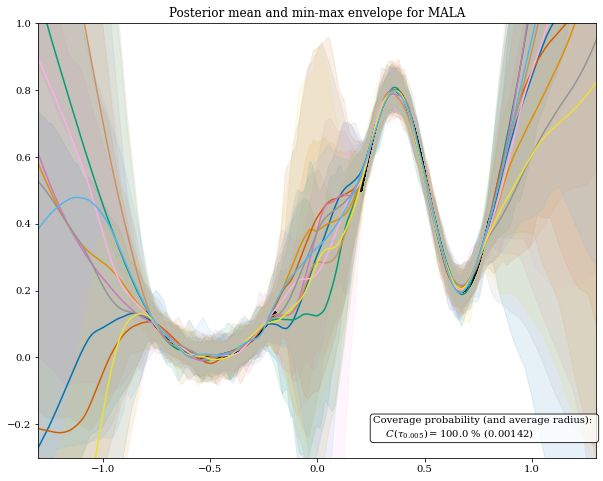

In [8]:
alpha = 0.005
out = calc_credible_balls(net, X, Y_true, alpha, folder, iterations, 'MHgd/')
print(f'C(tau_{alpha}) = ' + f'{out[0]*100} % ({out[1]} ± {out[2]})') #Wie mit Abstand von der Rändern?

out_theta = calc_credible_balls(net, X, Y_true, alpha, folder, iterations, 'MHgd/', theta = True, plot = '')
print(f'C(tau_theta_{alpha}) = ' + f'{out_theta[0]*100} % ({out_theta[1]} ± {out_theta[2]})') #Wie mit Abstand von der Rändern?

fig, ax = out[3]
ax.text(0.6,0.05, 'Coverage probability (and average radius): \n' +
        r'    $C(\tau_{0.005}) = $'+ f'{out[0]*100} % ({out[1]:.3})',
        #+ r'    $C(\log (n_\mathrm{train}) \tau^\theta_{0.005}) = $' + f'{out_theta[0]*100} % ({out_theta[1]:.3})',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), transform=ax.transAxes)
ax.set_title('Posterior mean and min-max envelope for MALA')

C(tau_0.005) = 100.0 % (0.01354384812945499± 0.0014087961246712895)
C(tau_theta_0.005) = 100.0 % (3.0525006477832792 ± 0.27765510730277637)


Text(0.5, 1.0, 'Posterior mean and min-max envelope for sMALA')

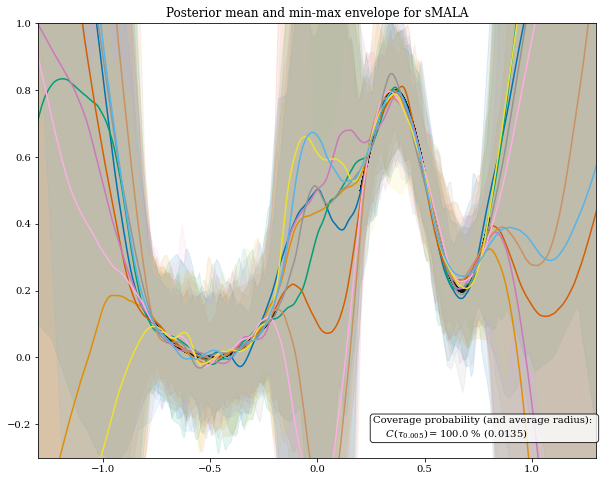

In [9]:
alpha = 0.005
out = calc_credible_balls(net, X, Y_true, alpha, folder, iterations, 'sMHgd/')
print(f'C(tau_{alpha}) = ' + f'{out[0]*100} % ({out[1]}± {out[2]})') #Wie mit Abstand von der Rändern?

out_theta = calc_credible_balls(net, X, Y_true, alpha, folder, iterations, 'sMHgd/', theta = True, plot = '')
print(f'C(tau_theta_{alpha}) = ' + f'{out_theta[0]*100} % ({out_theta[1]} ± {out_theta[2]})') #Wie mit Abstand von der Rändern?

fig, ax = out[3]
ax.text(0.6,0.05, 'Coverage probability (and average radius): \n' +
        r'    $C(\tau_{0.005}) = $'+ f'{out[0]*100} % ({out[1]:.3})',
        #+ r'    $C(\log (n_\mathrm{train}) \tau^\theta_{0.005}) = $' + f'{out_theta[0]*100} % ({out_theta[1]:.3})',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), transform=ax.transAxes)
ax.set_title('Posterior mean and min-max envelope for sMALA')

C(tau_0.005) = 100.0 % (0.007719674701802427 ± 0.0008223433678649737)
C(tau_theta_0.005) = 100.0 % (3.0030655149221417 ± 0.254637256763361)


Text(0.5, 1.0, 'Posterior mean and min-max envelope for csMALA')

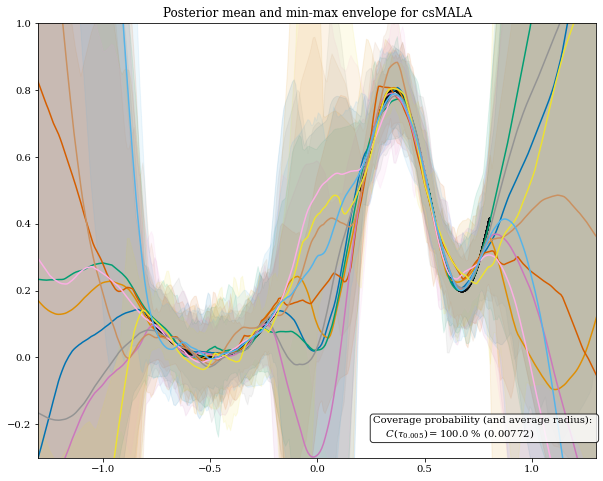

In [10]:
alpha = 0.005
out = calc_credible_balls(net, X, Y_true, alpha, folder, iterations, 'sMHgd_corr_lrRho/')
print(f'C(tau_{alpha}) = ' + f'{out[0]*100} % ({out[1]} ± {out[2]})') #Wie mit Abstand von der Rändern?

out_theta = calc_credible_balls(net, X, Y_true, alpha, folder, iterations, 'sMHgd_corr_lrRho/', theta = True, plot = '')
print(f'C(tau_theta_{alpha}) = ' + f'{out_theta[0]*100} % ({out_theta[1]} ± {out_theta[2]})') #Wie mit Abstand von der Rändern?

fig, ax = out[3]
ax.text(0.6,0.05, 'Coverage probability (and average radius): \n' +
        r'    $C(\tau_{0.005}) = $'+ f'{out[0]*100} % ({out[1]:.3})',
        #+ r'    $C(\log (n_\mathrm{train}) \tau^\theta_{0.005}) = $' + f'{out_theta[0]*100} % ({out_theta[1]:.3})',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8), transform=ax.transAxes)
ax.set_title('Posterior mean and min-max envelope for csMALA')

# Plots for paper

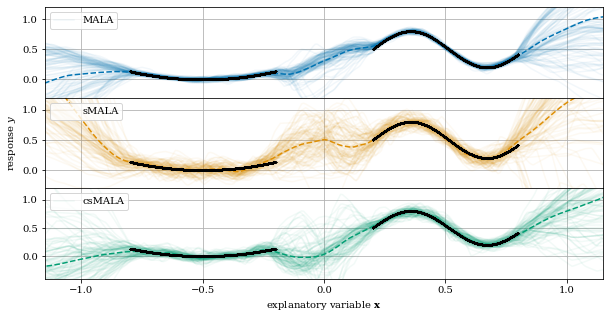

In [11]:
fig, axs = plt.subplots(3, 1, figsize=(10,5), sharex = True)
axs = axs.flatten()

X_plot = np.linspace(-2,2,500)


i = 0
folder_add = 'MHgd'

Y_sampled = get_samples(net, np.append(X_plot.reshape(-1,1), X, 0), folder+f'/{i}/'+folder_add) #torch.load(folder+f'/{i}/'+folder_add+'sampled_points.pt')
Y_plot =  Y_sampled.cpu().numpy()[:,:len(X_plot),:]
Y_sampled = Y_sampled.cpu().numpy()[:,len(X_plot):,:]

ax = axs[0]
for j in range(len(Y_plot)):
    if j==0:
        ax.plot(X_plot, Y_plot[j,:,0], alpha = 0.05, color = f'C0', label = 'MALA')
    else:
        ax.plot(X_plot, Y_plot[j,:,0], alpha = 0.05, color = f'C0')
ax.plot(X_plot, Y_plot.mean(0)[:,0], alpha = 1, color = f'C0', linestyle = '--')
ax.set_ylim(-0.3,1.2)
ax.set_xlim(-1.15,1.15)
ax.scatter(X, Y_true, marker = 'x', s=1, color = 'black', zorder=50)
ax.legend(loc='upper left')
ax.grid()


i = 0
folder_add = 'sMHgd'

Y_sampled = get_samples(net, np.append(X_plot.reshape(-1,1), X, 0), folder+f'/{i}/'+folder_add) #torch.load(folder+f'/{i}/'+folder_add+'sampled_points.pt')
Y_plot =  Y_sampled.cpu().numpy()[:,:len(X_plot),:]
Y_sampled = Y_sampled.cpu().numpy()[:,len(X_plot):,:]

ax = axs[1]
for j in range(len(Y_plot)):
    if j==0:
        ax.plot(X_plot, Y_plot[j,:,0], alpha = 0.05, color = f'C1', label = 'sMALA')
    else:
        ax.plot(X_plot, Y_plot[j,:,0], alpha = 0.05, color = f'C1')
ax.plot(X_plot, Y_plot.mean(0)[:,0], alpha = 1, color = f'C1', linestyle = '--')
ax.set_ylim(-0.3,1.2)
ax.set_xlim(-1.15,1.15)
ax.scatter(X, Y_true, marker = 'x', s=1, color = 'black', zorder=50)
ax.legend(loc='upper left')
ax.set_ylabel(r'response $y$')
ax.grid()


i = 7
folder_add = 'sMHgd_corr_lrRho'

Y_sampled = get_samples(net, np.append(X_plot.reshape(-1,1), X, 0), folder+f'/{i}/'+folder_add) #torch.load(folder+f'/{i}/'+folder_add+'sampled_points.pt')
Y_plot =  Y_sampled.cpu().numpy()[:,:len(X_plot),:]
Y_sampled = Y_sampled.cpu().numpy()[:,len(X_plot):,:]

ax = axs[2]
for j in range(len(Y_plot)):
    if j==0:
        ax.plot(X_plot, Y_plot[j,:,0], alpha = 0.05, color = f'C2', label = 'csMALA')
    else:
        ax.plot(X_plot, Y_plot[j,:,0], alpha = 0.05, color = f'C2')
ax.plot(X_plot, Y_plot.mean(0)[:,0], alpha = 1, color = f'C2', linestyle = '--')
ax.set_ylim(-0.4,1.2)
ax.set_xlim(-1.15,1.15)
ax.scatter(X, Y_true, marker = 'x', s=1, color = 'black', zorder=50)
ax.legend(loc='upper left')
ax.grid()
ax.set_xlabel(r'explanatory variable $\mathbf{x}$')

fig.subplots_adjust(hspace=0.)
fig.savefig(folder + '/fit.pdf')